<a href="https://colab.research.google.com/github/Stephen0111/NHSAandE/blob/main/NHS_AandE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# ===============================
# NHS A&E Performance Analysis & Predictive Modelling
# Dataset: AE_attendances_england_monthly.csv
# ===============================

# ===============================
# Step 0: Install required packages
# ===============================
!pip install pandas numpy matplotlib seaborn plotly scikit-learn xgboost lightgbm prophet folium geopandas requests kaggle kagglehub


In [18]:
# ===============================
# Step 1: Load Dataset
# ===============================
import kagglehub
import pandas as pd
import os

# Download/cache dataset
path = kagglehub.dataset_download("treich/ae-attendances-england")
print("Dataset path:", path)

# List files to see what's available
print("\nAvailable files:")
for file in os.listdir(path):
    print(file)

# Read the actual CSV file
df = pd.read_csv(f"{path}/AE_attendances_england_monthly.csv")
df.head()

Using Colab cache for faster access to the 'ae-attendances-england' dataset.
Dataset path: /kaggle/input/ae-attendances-england

Available files:
AE_attendances_england_monthly.csv


,Unnamed: 0,date,Name,Type 1 Departments - Major A&E,Type 2 Departments - Single Specialty,Type 3 Departments - Other A&E/Minor Injury Unit,Total attendances,Type 1 Departments - 4 hours to decision,Type 2 Departments - 4 hours to decision,Type 3 Departments - 4 hours to decision,Percentage in 4 hours or less (all),Emergency Admissions via Type 1 A&E in 4 hours,Emergency Admissions via Type 2 A&E in 4 hours,Emergency Admissions via Type 3 and 4 A&E in 4 hours,Other Emergency admissions (i.e not via A&E),Number of patients spending >12 hours from decision to admit to admission,month,year,lat,lon
0,0,2010-11-01,Aintree University Hospitals NHS Foundation Trust,4622.0,0.0,0.0,4622.0,7.0,0.0,0.0,2.995435,1406.0,0.0,0.0,530.0,0.0,44.0,8040.0,53.461606,-2.943427
1,1,2010-11-01,Airedale NHS Trust,3965.0,0.0,0.0,3965.0,65.0,0.0,0.0,3.934107,892.0,0.0,0.0,568.0,0.0,44.0,8040.0,NaN,NaN
2,2,2010-11-01,Alder Hey Children’S NHS Foundation Trust,4541.0,0.0,0.0,4541.0,71.0,0.0,0.0,3.937936,1825.0,0.0,0.0,270.0,0.0,44.0,8040.0,50.183000,-5.416000
3,3,2010-11-01,Ashford And St Peter'S Hospitals NHS Trust,7010.0,0.0,769.0,7779.0,392.0,0.0,0.0,3.797332,1902.0,0.0,0.0,163.0,0.0,44.0,8040.0,51.655000,-0.395694
4,4,2010-11-01,"Ashton, Leigh And Wigan Primary Care Trust",0.0,0.0,4297.0,4297.0,0.0,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,44.0,8040.0,51.272000,0.529000


In [19]:

# ===============================
# Step 2: Data Cleaning & Preprocessing
# ===============================
# Fix date, month & year
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Re-generate month & year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Check
df[['date','month','year']].head()



,date,month,year
0,2010-11-01,11,2010
1,2010-11-01,11,2010
2,2010-11-01,11,2010
3,2010-11-01,11,2010
4,2010-11-01,11,2010


In [14]:
# Fill NaN lat/lon with zeros (or drop if needed)
df[['lat','lon']] = df[['lat','lon']].fillna(0)

# Fill numeric NaNs with 0
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(0)

df.head()


,Unnamed: 0,date,Name,Type 1 Departments - Major A&E,Type 2 Departments - Single Specialty,Type 3 Departments - Other A&E/Minor Injury Unit,Total attendances,Type 1 Departments - 4 hours to decision,Type 2 Departments - 4 hours to decision,Type 3 Departments - 4 hours to decision,Percentage in 4 hours or less (all),Emergency Admissions via Type 1 A&E in 4 hours,Emergency Admissions via Type 2 A&E in 4 hours,Emergency Admissions via Type 3 and 4 A&E in 4 hours,Other Emergency admissions (i.e not via A&E),Number of patients spending >12 hours from decision to admit to admission,month,year,lat,lon
0,0,2010-11-01,Aintree University Hospitals NHS Foundation Trust,4622.0,0.0,0.0,4622.0,7.0,0.0,0.0,2.995435,1406.0,0.0,0.0,530.0,0.0,11,2010,53.461606,-2.943427
1,1,2010-11-01,Airedale NHS Trust,3965.0,0.0,0.0,3965.0,65.0,0.0,0.0,3.934107,892.0,0.0,0.0,568.0,0.0,11,2010,0.000000,0.000000
2,2,2010-11-01,Alder Hey Children’S NHS Foundation Trust,4541.0,0.0,0.0,4541.0,71.0,0.0,0.0,3.937936,1825.0,0.0,0.0,270.0,0.0,11,2010,50.183000,-5.416000
3,3,2010-11-01,Ashford And St Peter'S Hospitals NHS Trust,7010.0,0.0,769.0,7779.0,392.0,0.0,0.0,3.797332,1902.0,0.0,0.0,163.0,0.0,11,2010,51.655000,-0.395694
4,4,2010-11-01,"Ashton, Leigh And Wigan Primary Care Trust",0.0,0.0,4297.0,4297.0,0.0,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,11,2010,51.272000,0.529000


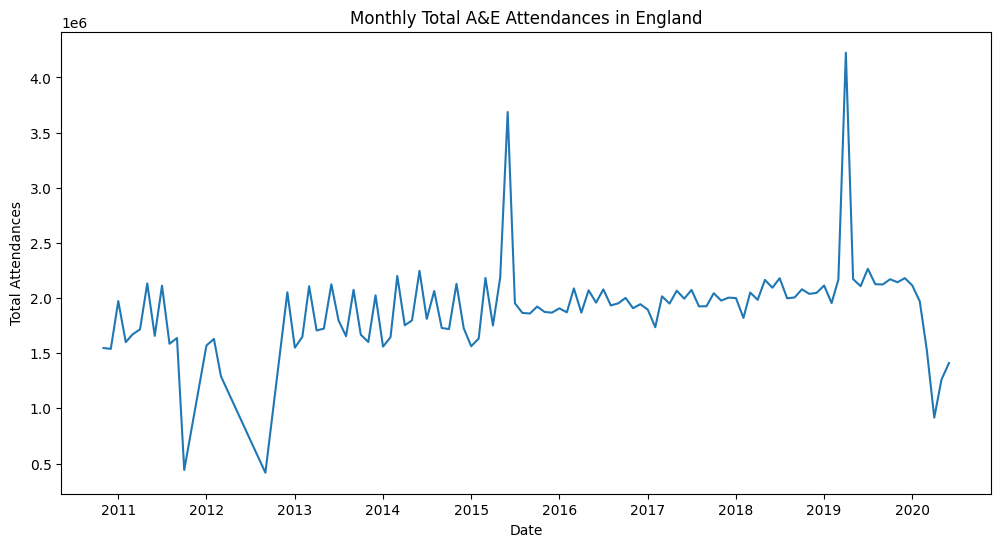

In [20]:
# ===============================
# Step 3: Exploratory Data Analysis
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate monthly total attendances
df_monthly = df.groupby('date')['Total attendances'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthly, x='date', y='Total attendances')
plt.title("Monthly Total A&E Attendances in England")
plt.ylabel("Total Attendances")
plt.xlabel("Date")
plt.show()


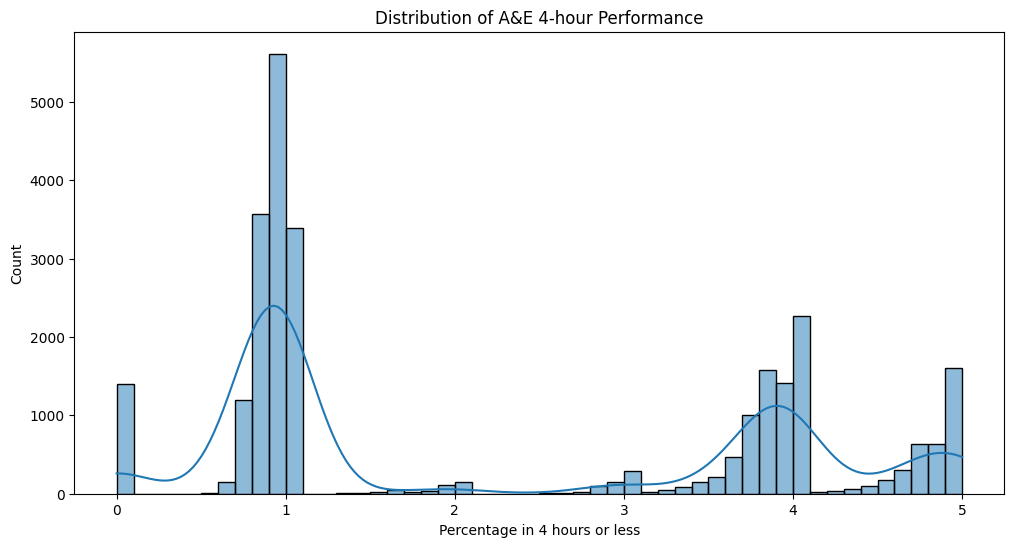

In [16]:
# 4 Hour Performance
plt.figure(figsize=(12,6))
sns.histplot(df['Percentage in 4 hours or less (all)'], bins=50, kde=True)
plt.title("Distribution of A&E 4-hour Performance")
plt.xlabel("Percentage in 4 hours or less")
plt.show()


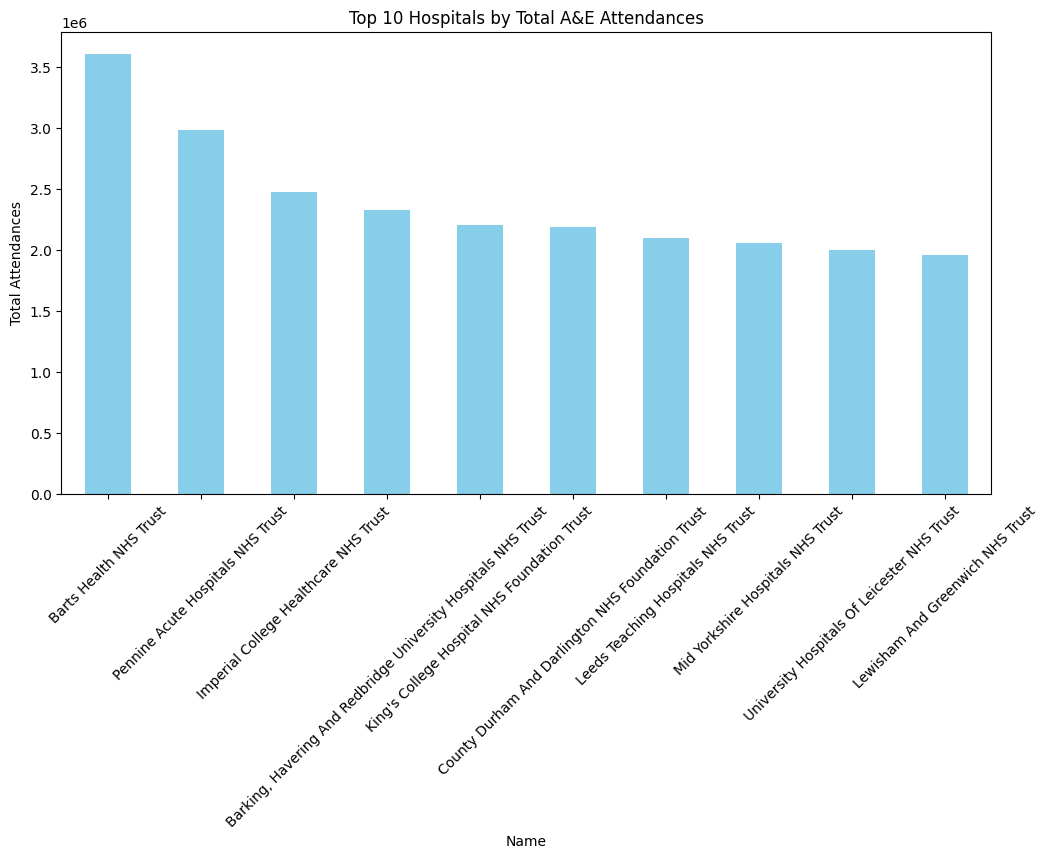

In [21]:
# Top 10 hospitals by attendances
top_hospitals = df.groupby('Name')['Total attendances'].sum().sort_values(ascending=False).head(10)
top_hospitals.plot(kind='bar', figsize=(12,6), color='skyblue')
plt.title("Top 10 Hospitals by Total A&E Attendances")
plt.ylabel("Total Attendances")
plt.xticks(rotation=45)
plt.show()

In [22]:

# ===============================
# Step 4: Map Visualization
# ===============================
import folium

map_center = [54.0, -2.0]
m = folium.Map(location=map_center, zoom_start=6)

df_map = df.groupby(['Name','lat','lon'])['Total attendances'].mean().reset_index()

for i, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"{row['Name']}: {row['Total attendances']:.0f} avg attendances",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m



In [23]:
# ===============================
# Step 5: Feature Engineering
# ===============================
df = df.sort_values(['Name','date'])
df['Total_attendances_Lag1'] = df.groupby('Name')['Total attendances'].shift(1)
df['Total_attendances_Lag3'] = df.groupby('Name')['Total attendances'].shift(3)
df['Target_4h_met'] = (df['Percentage in 4 hours or less (all)'] >= 95).astype(int)


In [24]:
# ===============================
# Step 6A: Classification - 4-hour Target
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

features = ['Total attendances','Total_attendances_Lag1','Total_attendances_Lag3','month']
X = df[features].fillna(0)
y = df['Target_4h_met']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5423

    accuracy                           1.00      5423
   macro avg       1.00      1.00      1.00      5423
weighted avg       1.00      1.00      1.00      5423



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


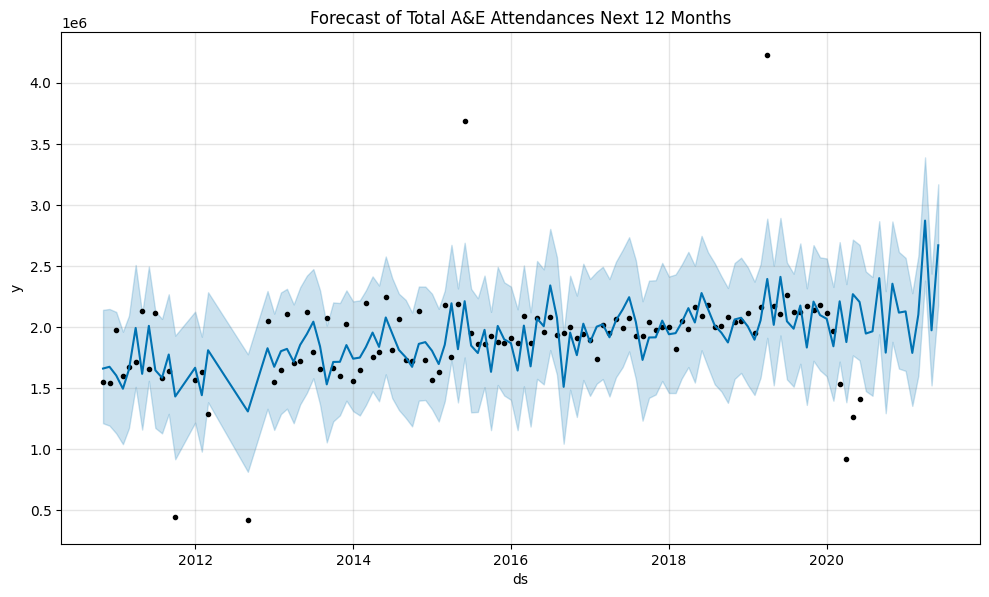

In [26]:
# ===============================
# Step 6B: Forecasting - Total Attendances
# ===============================
from prophet import Prophet

df_prophet = df.groupby('date')['Total attendances'].sum().reset_index().rename(columns={'date':'ds','Total attendances':'y'})

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

model.plot(forecast)
plt.title("Forecast of Total A&E Attendances Next 12 Months")
plt.show()

Top 10 Hospitals Missing 4-hour Target Most Often:
Name
Southport And Ormskirk Hospital NHS Trust                107
Yeovil District Hospital NHS Foundation Trust            107
Surrey And Sussex Healthcare NHS Trust                   107
South Tees Hospitals NHS Foundation Trust                107
Stockport NHS Foundation Trust                           107
Barnsley Hospital NHS Foundation Trust                   107
South West Yorkshire Partnership NHS Foundation Trust    107
Mid Cheshire Hospitals NHS Foundation Trust              107
Medway NHS Foundation Trust                              107
Poole Hospital NHS Foundation Trust                      107
dtype: int64


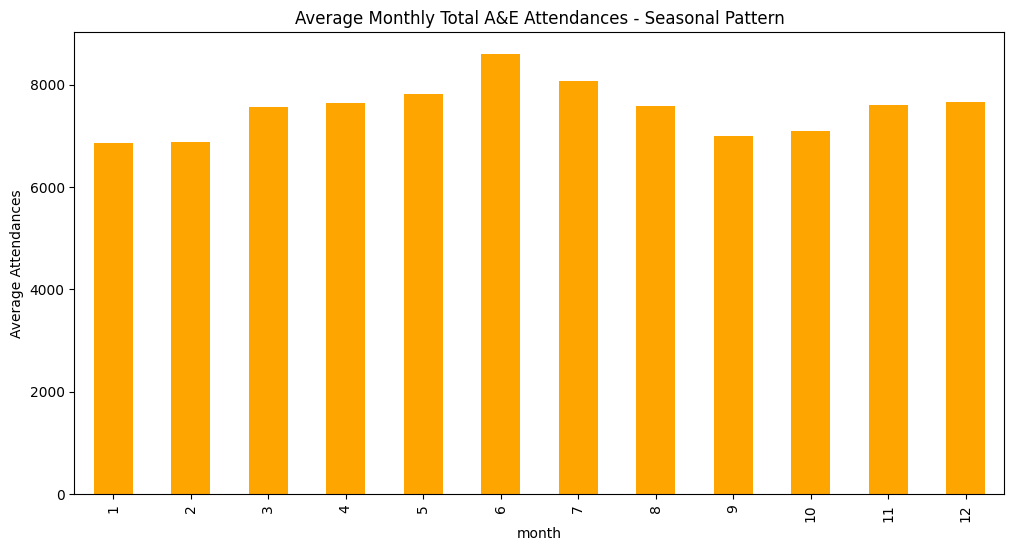

In [29]:
# ===============================
# Step 7: Insights & Reporting
# ===============================
# - Hospitals consistently missing 4-hour target
missed_hospitals = df[df['Target_4h_met']==0].groupby('Name').size().sort_values(ascending=False).head(10)
print("Top 10 Hospitals Missing 4-hour Target Most Often:")
print(missed_hospitals)

# - Seasonal patterns
df['month'] = df['date'].dt.month
monthly_avg = df.groupby('month')['Total attendances'].mean()
plt.figure(figsize=(12,6))
monthly_avg.plot(kind='bar', color='orange')
plt.title("Average Monthly Total A&E Attendances - Seasonal Pattern")
plt.ylabel("Average Attendances")
plt.show()

In [28]:
# ===============================
# Step 8: Interactive Plotly Dashboard
# ===============================
import plotly.express as px
import plotly.graph_objects as go

# Prepare data
df_plot = df.copy()
df_plot['Hospital'] = df_plot['Name']

# 1. Total Attendances Over Time per Hospital
fig1 = px.line(
    df_plot,
    x='date',
    y='Total attendances',
    color='Hospital',
    title='Monthly Total A&E Attendances by Hospital',
    hover_data={'Total attendances':':,.0f'}
)
fig1.update_layout(height=600, width=900)
fig1.show()

# 2. 4-hour Target Percentage Over Time
fig2 = px.line(
    df_plot,
    x='date',
    y='Percentage in 4 hours or less (all)',
    color='Hospital',
    title='A&E 4-hour Target Performance by Hospital',
    hover_data={'Percentage in 4 hours or less (all)':':.2f'}
)
fig2.update_layout(height=600, width=900)
fig2.add_hline(y=95, line_dash="dash", line_color="red", annotation_text="Target 95%", annotation_position="top left")
fig2.show()

# 3. Scatter Map of Hospitals with Avg Attendances & 4-hour Performance
df_map_avg = df_plot.groupby(['Hospital','lat','lon']).agg({
    'Total attendances':'mean',
    'Percentage in 4 hours or less (all)':'mean'
}).reset_index()

fig3 = px.scatter_mapbox(
    df_map_avg,
    lat='lat',
    lon='lon',
    size='Total attendances',
    color='Percentage in 4 hours or less (all)',
    hover_name='Hospital',
    color_continuous_scale=px.colors.sequential.YlGnBu,
    size_max=25,
    zoom=5,
    mapbox_style='carto-positron',
    title='Hospital Locations with Avg Attendances & 4-hour Target %'
)
fig3.show()

# 4. Seasonal Pattern: Avg Attendances per Month
df_plot['Month'] = df_plot['date'].dt.month
monthly_avg = df_plot.groupby('Month')['Total attendances'].mean().reset_index()

fig4 = px.bar(
    monthly_avg,
    x='Month',
    y='Total attendances',
    text='Total attendances',
    title='Average Monthly Total A&E Attendances - Seasonal Pattern'
)
fig4.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig4.update_layout(yaxis_title="Average Attendances", xaxis_title="Month", height=500)
fig4.show()
